In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport deepsvr

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
from analysis_utils.Analysis import print_accuracy_and_classification_report, predict_classes, get_somatic_error_type

sns.set_style("white")
sns.set_context('poster')

In [4]:
# Pull in training data
training_data = pd.read_pickle('data/training_data_preprocessed.pkl')
training_data.sort_index(axis=1, inplace=True)

In [5]:
# Remove AML31 case
aml31_training = training_data[training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]
training_data = training_data[~training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]

In [6]:
# Show the calls associate with training data
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [7]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Somatic, ambigous, fail classifier

In [8]:
# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [9]:
# Show the calls associate with training data
three_class.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [10]:
# Get labels for training data
Y = three_class.call.values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [11]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [12]:
# Determine shape of training data features for cross-validation
X_train.shape

(27470, 71)

In [13]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(27470,)

In [14]:
# Set parameters for the Extra Trees Classifier Model
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)

In [15]:
#Perform cross validation and pull AUC for various splits
# auc = []
# for n in [100, 1000, 10000]:
#     est = ExtraTreesClassifier(n_estimators=n, max_features=8,n_jobs=-1)
#     probs = cross_val_predict(est, X_train, Y_train, cv=kfold, method='predict_proba')
#     temp_auc = []
#     for j in range(Y_one_hot.shape[1]):
#         temp_auc.append(metrics.roc_auc_score(Y_one_hot[:, j], probs[:, j]))
#     auc.append(temp_auc)
#     print('Test AUC for {0} trees: '.format(n), temp_auc)
#     print('---------------------------------------------------------')

In [16]:
# Set parameters for the estimator
estimator = ExtraTreesClassifier(n_estimators=100, max_features=8, 
                                   n_jobs=-1)

In [17]:
# Perform cross validation
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [19]:
# print accuracy report
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.8927921368765926

Cross validation classification report

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      7189
           1       0.91      0.93      0.92      8015
           2       0.90      0.94      0.92     12266

   micro avg       0.89      0.89      0.89     27470
   macro avg       0.89      0.88      0.88     27470
weighted avg       0.89      0.89      0.89     27470
 samples avg       0.89      0.89      0.89     27470



## Feature importance analysis

In [22]:
# Rebuild random Extra Trees model
trees = estimator.fit(X_train, Y_train)

In [24]:
# Create function to determine the feature importance 
def create_feature_importance_plot(trained_model, save_fp='data/trees/feature_import.pkl'):
    feature_import = pd.DataFrame([training_data.drop(['call'], axis=1).columns.values,trained_model.feature_importances_]).T
    feature_import.columns = ['feature', 'importance']
    feature_import.to_pickle(save_fp)
    feature_import.sort_values('importance', ascending=False, inplace=True)
    feature_import.replace({'feature':{'var':'variant','ref':'reference', 'avg':'average', '_se_':'_single_end_', '3p':'3_prime', '_':' '}}, regex=True, inplace=True)
    sns.barplot(y='feature', x='importance', data=feature_import.head(10), color='darkorange')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Extra Trees Feature Importance')

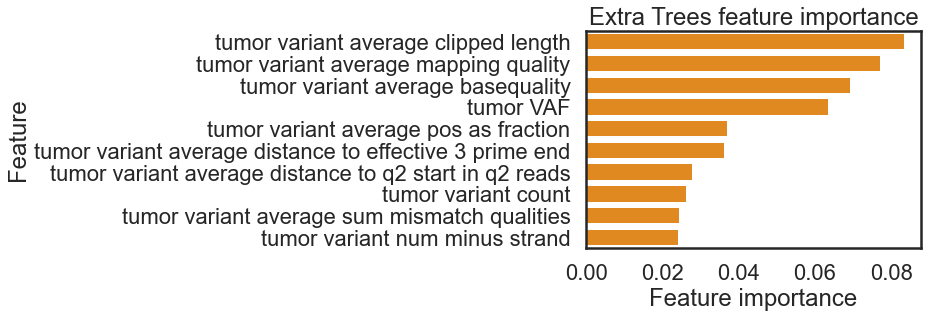

In [25]:
# Plot feature importance graph
create_feature_importance_plot(trees)

### Test set performance

In [26]:
# Determine performance on test set
test_prob = trees.predict_proba(X_test)

In [27]:
# Transform labels for predictions
Y_test_labels = enc.fit_transform(Y_test)

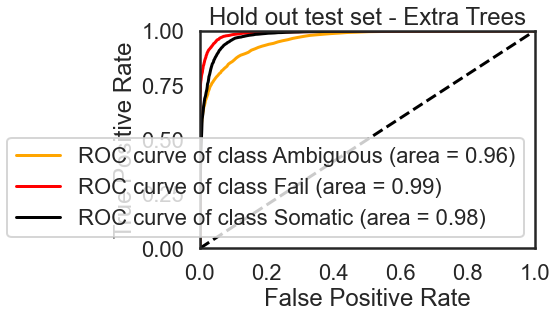

In [28]:
# Plot ROC for test set
fig, ax = plt.subplots()
create_roc_curve(Y_test_labels, test_prob, class_lookup,
                 'Hold out test set - '
                 'Extra Trees', ax)